Мы располагаем данными из открытых источников о продажах игр. Чтобы выявить закономерности определяющие успешность игры, мы проанализируем эти данные ниже. Нам в первую очередь необходимо найти потенциально популярный продукт, чтобы сделать на него ставку.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

## Загрузка файла

In [2]:
data = pd.read_csv('/datasets/games.csv')

## Подготовка данных

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Название столбцов

Приведем названия столбцов к нижнему регистру

In [4]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [5]:
#data = data.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release',
#             'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales',
#             'JP_sales':'jp_sales', 'Other_sales':'other_sales', 'Critic_Score':'critic_score',
#             'User_Score':'user_score', 'Rating':'rating'})

In [6]:
for column in data.columns:
    data = data.rename(columns={column:column.lower()})

### Пропуски

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Столбцы name, genre скорее всего будут вместе отсутствовать. Посмотрим на строки с пропусками в них.

In [8]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


У них отсутствует очень много информации. Думаю можно удалить именно эти строки.

In [10]:
cleared_data = data.drop(data[data['name'].isna()].index)

Думаю можно заменить год релиза на год последней игры выпущенной на платформе. 

In [11]:
for platform in cleared_data['platform'].unique():
    cleared_data.loc[(cleared_data['platform'] == platform) & (cleared_data['year_of_release'].isna()), 'year_of_release'] = (
        cleared_data.groupby(['platform'])['year_of_release'].max()[platform]
    )

In [12]:
cleared_data['year_of_release'].isna().sum()

0

In [13]:
cleared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Дальше посмотрим user_score, потому что у него даже выделяющийся тип данных. 

In [14]:
cleared_data['user_score'].describe()

count     10014
unique       96
top         tbd
freq       2424
Name: user_score, dtype: object

In [15]:
cleared_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Выделяется значение TBD (to be decided). Значит оценка еще не дана. Думаю имеет смысл добавить столбец отдельно для того, чтобы показать дана ли оценка от юзеров или нет.

Рейтинг ESRB действителен в первую очередь для Америки, для Европы и Японии используются преимущественно другие рейтинги. Потому здесь пропуски это нормально, заменим их на 'tbd'.

In [16]:
cleared_data['rating'].fillna('tbd', inplace=True)

cleared_data['user_score_decided'] = cleared_data['user_score']
cleared_data.loc[cleared_data['user_score_decided'] != 'tbd', 'user_score_decided'] = 'd'

*'d'* - как сокращение от decided.

In [17]:
cleared_data['user_score_decided'].unique()

array(['d', 'tbd'], dtype=object)

После этого удалим тогда 'tbd' из 'user_score'. Заменим на 'nan'.

In [18]:
cleared_data.loc[cleared_data['user_score'] == 'tbd', 'user_score'] = np.nan

In [19]:
cleared_data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

Теперь посмотрим столбцы с рейтингом и оценками вместе. Они должны быть очень близки и значения можно будет сопоставить.

In [20]:
cleared_data[['critic_score', 'user_score', 'rating']]

,critic_score,user_score,rating
0,76.0,8,E
1,NaN,NaN,tbd
2,82.0,8.3,E
3,80.0,8,E
4,NaN,NaN,tbd
...,...,...,...
16710,NaN,NaN,tbd
16711,NaN,NaN,tbd
16712,NaN,NaN,tbd
16713,NaN,NaN,tbd


Похоже что есть строки, где все значения отсутствуют. 

In [21]:
cleared_data[(~cleared_data['critic_score'].isna())&(cleared_data['user_score'].isna())].shape[0]

1120

Получается есть строки, где присутствует оценка от критиков, но не от пользователей.

In [22]:
cleared_data[(cleared_data['critic_score'].isna())&(~cleared_data['user_score'].isna())].shape[0]

573

А также есть и строки, где почему то отсутствуют оценки от критиков. 

Оценим корреляцию оценки критиков и пользователей.

In [23]:
(
    pd.to_numeric(cleared_data['critic_score'])
    .corr(pd.to_numeric(cleared_data['user_score'], errors='coerce') * 10)
)

0.5808778320767233

Довольно высокий коэффициент. Думаю можно тогда заменить отсутствующие значения в одном подменой на значение из другого столбца.

In [24]:
cleared_data.loc[(cleared_data['critic_score'].isna())&(~cleared_data['user_score'].isna()), 'critic_score'] = (
    pd.to_numeric(
        cleared_data.loc[(cleared_data['critic_score'].isna())&(~cleared_data['user_score'].isna()), 'user_score']
    ) * 10
)

In [25]:
cleared_data.loc[(~cleared_data['critic_score'].isna())&(cleared_data['user_score'].isna()), 'user_score'] = (
    pd.to_numeric(
        cleared_data.loc[(~cleared_data['critic_score'].isna())&(cleared_data['user_score'].isna()), 'critic_score']
    ) / 10
)

Остальные значения оставим пустыми.

### Приведение к нужному типу

Надо поменять year_of_release на int (потому что год это целое число), critic_score на int (потому что оценка критика это число от 0 до 100) и user_score на float (из-за одного значения столбец был объектовым, но теперь нужно поменять на число с плавающей точкой).

In [26]:
cleared_data = cleared_data.convert_dtypes(convert_string=False)

Функция автоматически заменяет, потому проверим.

In [27]:
cleared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                16713 non-null  object 
 1   platform            16713 non-null  object 
 2   year_of_release     16713 non-null  Int64  
 3   genre               16713 non-null  object 
 4   na_sales            16713 non-null  Float64
 5   eu_sales            16713 non-null  Float64
 6   jp_sales            16713 non-null  Float64
 7   other_sales         16713 non-null  Float64
 8   critic_score        8710 non-null   Int64  
 9   user_score          8710 non-null   object 
 10  rating              16713 non-null  object 
 11  user_score_decided  16713 non-null  object 
dtypes: Float64(4), Int64(2), object(6)
memory usage: 1.8+ MB


user_score - не поменял тип, потому сделаем вручную это.

In [28]:
cleared_data['user_score'] = pd.to_numeric(cleared_data['user_score'], errors='coerce')

In [29]:
cleared_data['user_score'].dtype

dtype('float64')

Заменим отсутствующие значения на tbd.

In [30]:
cleared_data['rating'].fillna('tbd', inplace=True)

### Продажи по регионам

In [31]:
cleared_data['total_sales'] = (
    cleared_data['na_sales'] + cleared_data['eu_sales'] + cleared_data['jp_sales'] + cleared_data['other_sales']
)

## Исследовательский анализ

In [32]:
# Поменяем стиль на что-то более приятное
plt.style.use('seaborn')

### Продажи по годам

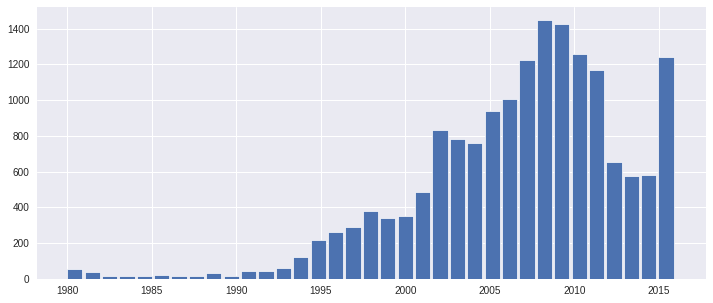

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(cleared_data['year_of_release'], width=0.9, bins=35, edgecolor="white", linewidth=0.7)

plt.show()

По графику видно, что после 90-х выпускали все больше и больше игр с каждым годом, за исключением 12-14 годов.

Думаю данные можно брать после 94-го года, так как до него выпускали мизерное кол-во игр.

### Продажи по платформам

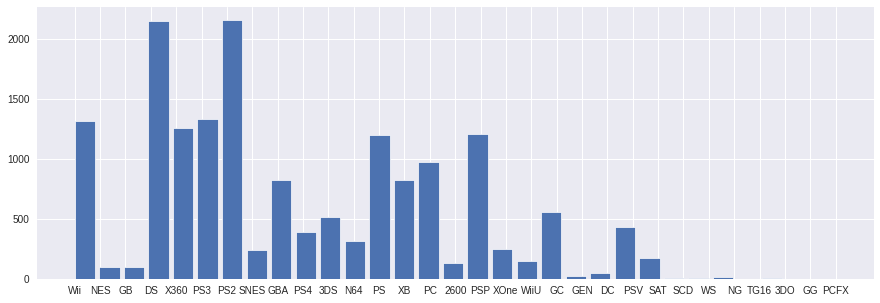

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.hist(cleared_data['platform'], width=0.8, bins=31, edgecolor="white", linewidth=0.7)

plt.show()

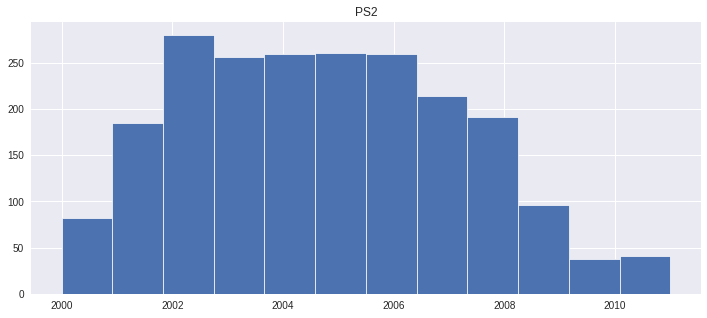

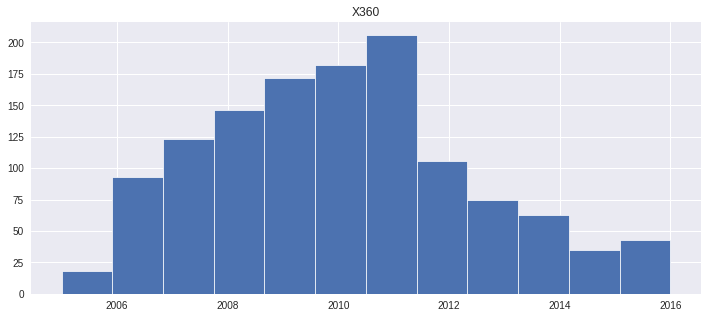

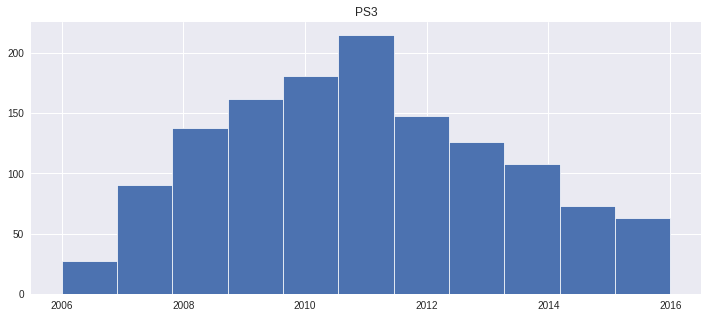

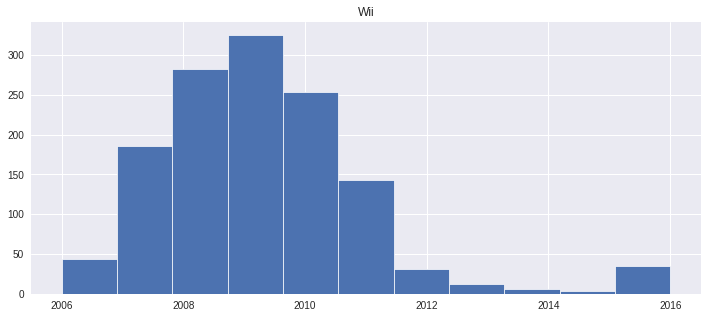

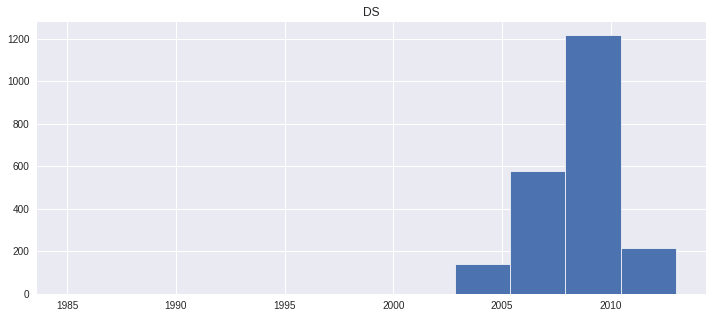

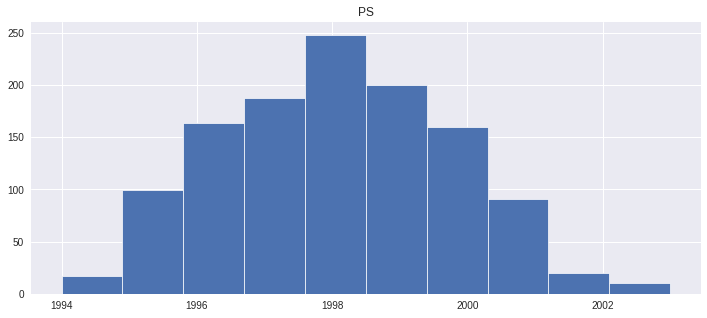

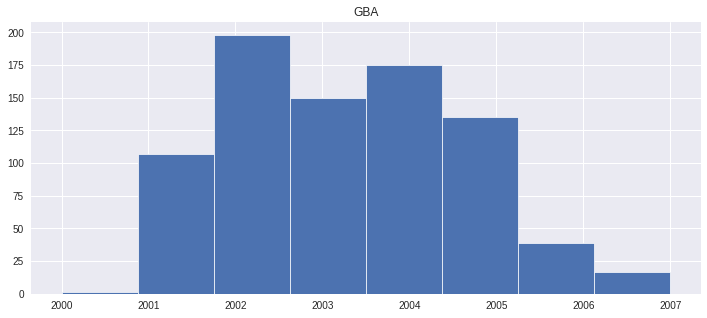

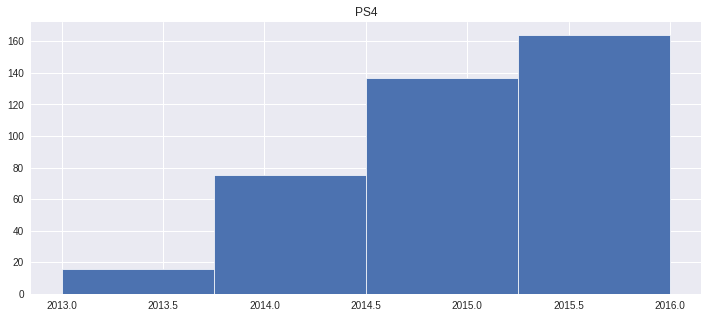

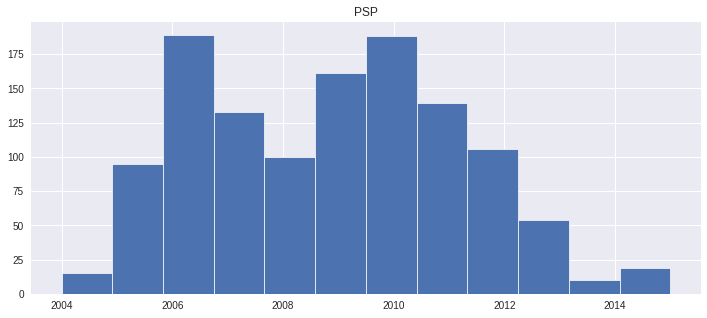

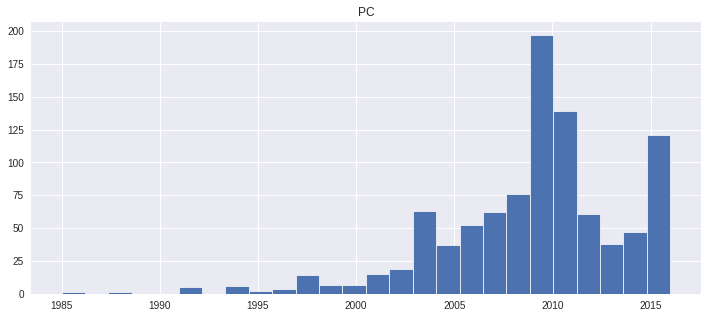

In [35]:
for platform in list(cleared_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:10].index):
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title(platform)
    ax.hist(cleared_data[cleared_data['platform'] == platform]['year_of_release'],
            bins=cleared_data[cleared_data['platform'] == platform]['year_of_release'].unique().shape[0],
            edgecolor="white", linewidth=0.7)
    plt.show()

In [36]:
temp = (
    cleared_data.loc[:, ['platform', 'year_of_release']]
    .drop_duplicates()
    .groupby(by='platform').count()['year_of_release']
)
temp

platform
2600    10
3DO      2
3DS      6
DC       7
DS      11
GB      13
GBA      8
GC       7
GEN      5
GG       1
N64      7
NES     12
NG       4
PC      26
PCFX     1
PS      10
PS2     12
PS3     11
PS4      4
PSP     12
PSV      6
SAT      6
SCD      2
SNES    10
TG16     1
WS       3
Wii     11
WiiU     5
X360    12
XB       9
XOne     4
Name: year_of_release, dtype: int64

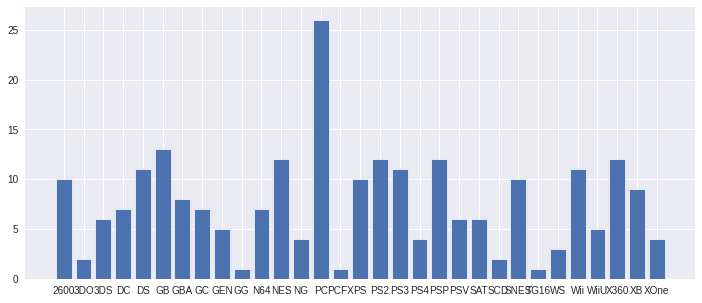

In [37]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(temp.index,
       temp,
       edgecolor="white", linewidth=0.7)

ax.plot();

In [38]:
temp.describe()

count    31.000000
mean      7.677419
std       5.081910
min       1.000000
25%       4.000000
50%       7.000000
75%      11.000000
max      26.000000
Name: year_of_release, dtype: float64

Средний срок жизни платформ 7 лет.

### Актуальный период

За актуальный период возьмем половину срока жизни платформы. 

In [39]:
actual_data = cleared_data[cleared_data['year_of_release'] > (2016 - 3)]

Сделаем так, чтобы взять захватить уже умершие платформы.

### Платформы с потенциалом

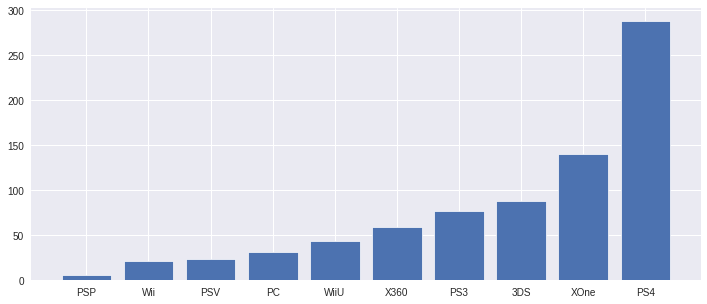

In [40]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(actual_data.groupby('platform')['total_sales'].sum().sort_values().index, 
       actual_data.groupby('platform')['total_sales'].sum().sort_values(),
       edgecolor="white", linewidth=0.7)

ax.plot();

In [41]:
actual_data.groupby('platform')['total_sales'].sum().sort_values()

platform
PSP       4.88
Wii       21.4
PSV      22.66
PC       30.81
WiiU     42.98
X360      58.4
PS3      76.49
3DS      87.87
XOne    140.36
PS4     288.15
Name: total_sales, dtype: Float64

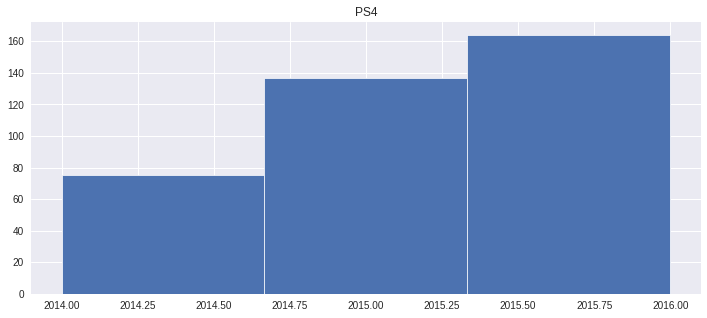

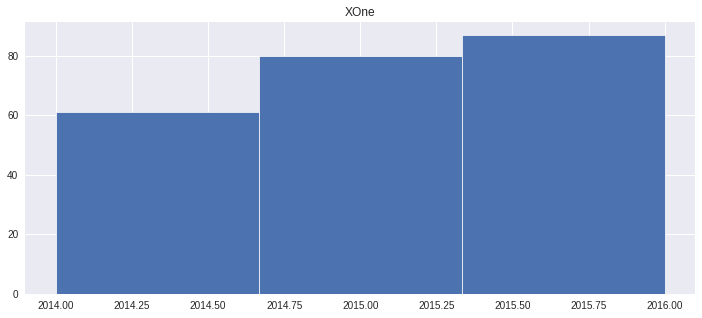

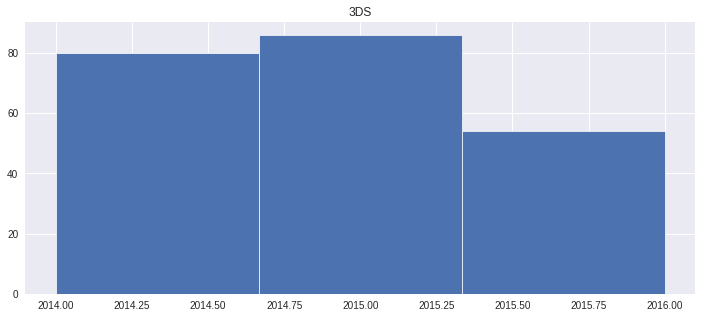

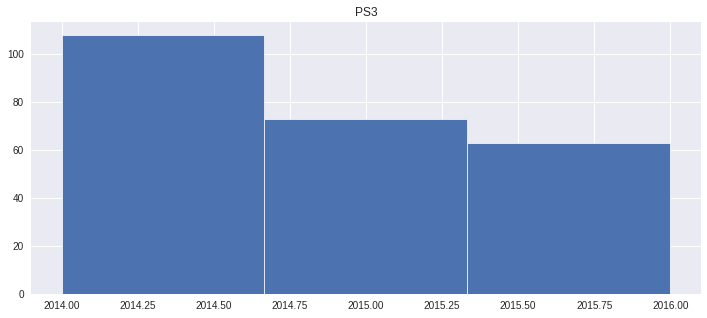

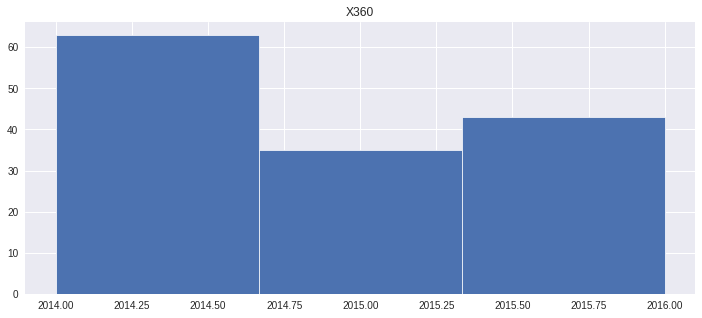

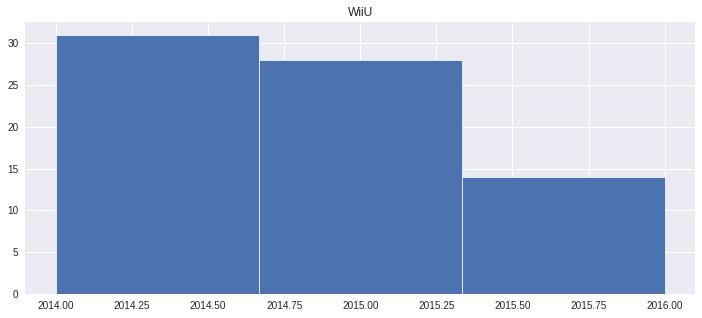

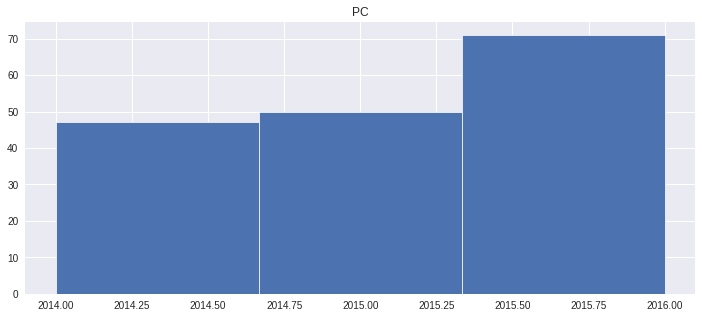

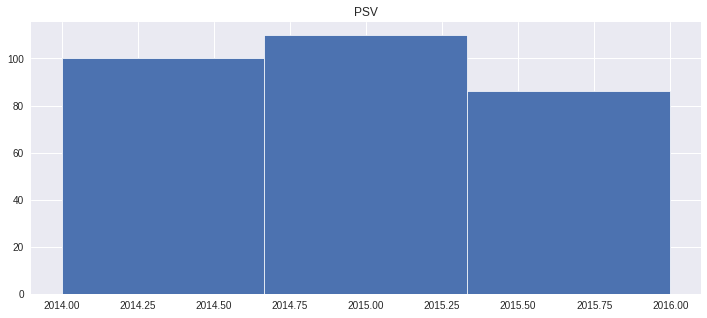

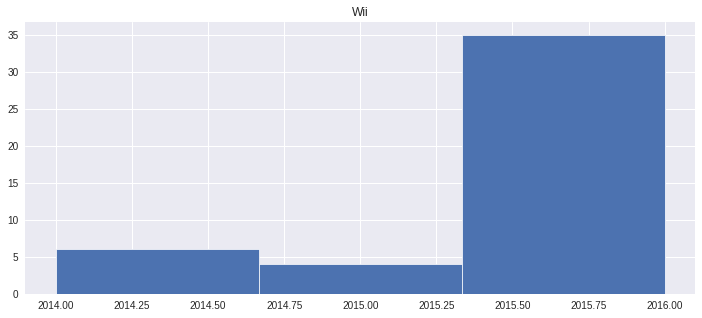

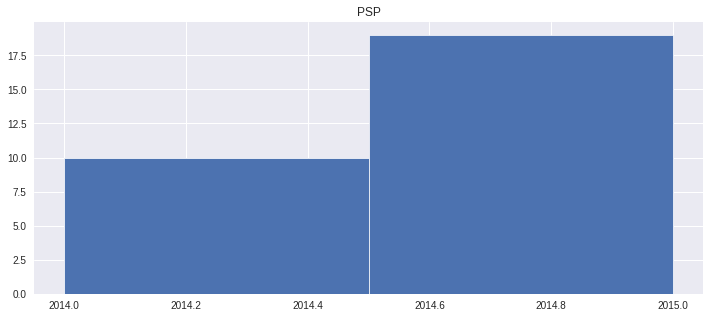

In [42]:
temp = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:10]

for platform in temp.index:
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title(platform)
    ax.hist(actual_data[actual_data['platform'] == platform]['year_of_release'], 
            bins=actual_data[actual_data['platform'] == platform]['year_of_release'].unique().shape[0]
            , edgecolor="white", linewidth=0.7)
    plt.show()

In [43]:
temp = actual_data.pivot_table('total_sales', ['year_of_release', 'platform'], aggfunc='sum')
temp['platform'] = temp.index
temp

total_sales      platform
year_of_release platform                           
2014            3DS             43.76   (2014, 3DS)
                PC              13.28    (2014, PC)
                PS3             47.76   (2014, PS3)
                PS4             100.0   (2014, PS4)
                PSP              0.24   (2014, PSP)
                PSV              11.9   (2014, PSV)
                Wii              3.75   (2014, Wii)
                WiiU            22.03  (2014, WiiU)
                X360            34.74  (2014, X360)
                XOne            54.07  (2014, XOne)
2015            3DS             27.78   (2015, 3DS)
                PC               8.52    (2015, PC)
                PS3             16.82   (2015, PS3)
                PS4             118.9   (2015, PS4)
                PSP              4.64   (2015, PSP)
                PSV              6.25   (2015, PSV)
                Wii              1.14   (2015, Wii)
                WiiU            16.35  (2015, WiiU)
                X360            11.96  (2015, X360)
                XOne            60.14  (2015, XOne)
2016            3DS             16.33   (2016, 3DS)
                PC               9.01    (2016, PC)
                PS3             11.91   (2016, PS3)
                PS4             69.25   (2016, PS4)
                PSV              4.51   (2016, PSV)
                Wii             16.51   (2016, Wii)
                WiiU              4.6  (2016, WiiU)
                X360             11.7  (2016, X360)
                XOne            26.15  (2016, XOne)

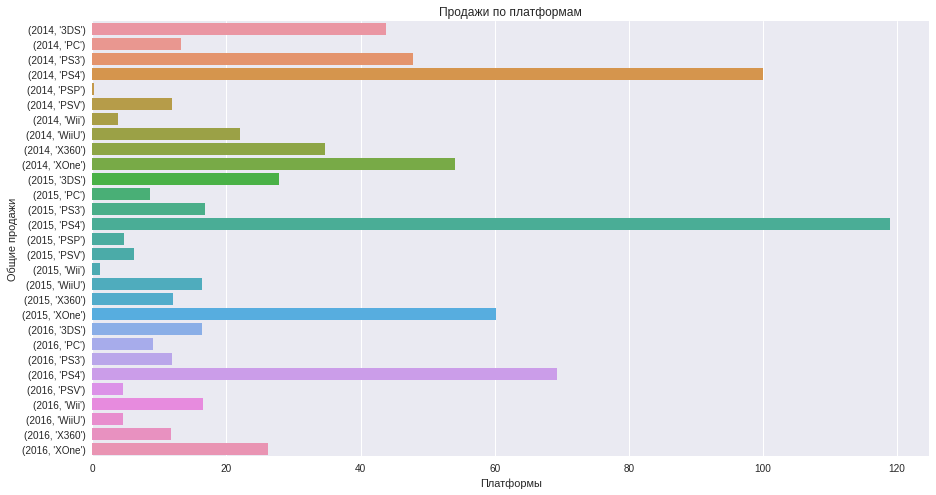

In [44]:
plt.figure(figsize=(15, 8))
(
    sns.barplot(data=temp, x='total_sales',y='platform')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи')
    
)

plt.show()

По продажам лидируют X360, PS3, Wii. Это платформы, которые отжили свой полный цикл, потому продажи у них падают.

Самыми перспективными можно считать PS4, XOne. У них ярко выражено увелечение объема продаж, вероятно из-за того, что это следующее поколение самых прибыльных платформ. 

### Ящик с усами

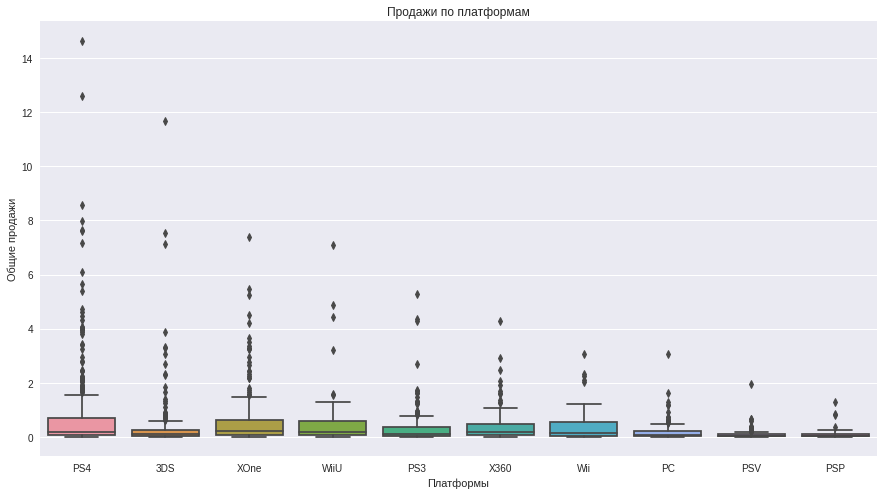

In [45]:
plt.figure(figsize=(15, 8))
temp = actual_data

(
    sns.boxplot(data = temp, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи')
    
)

plt.show()

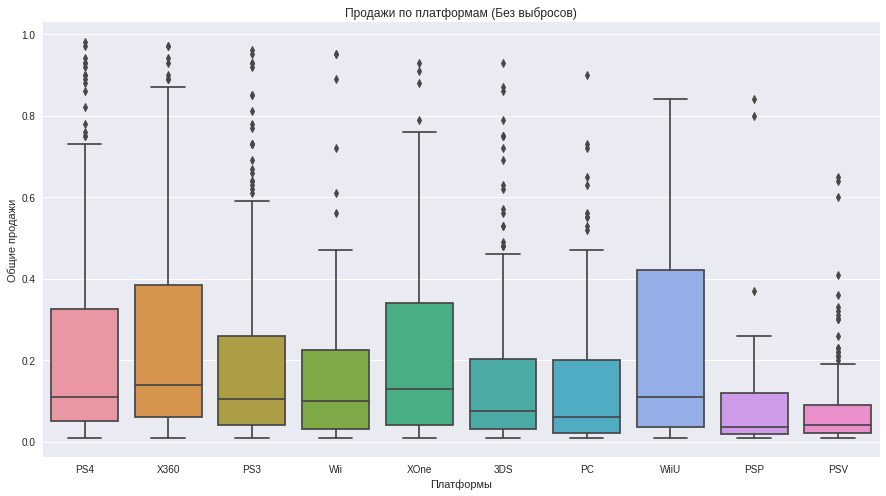

In [46]:
plt.figure(figsize=(15, 8))
temp = actual_data.loc[actual_data['total_sales'] < 1]

(
    sns.boxplot(data = temp, y = 'total_sales', x='platform')
    .set(title = 'Продажи по платформам (Без выбросов)', xlabel = 'Платформы', ylabel = 'Общие продажи')
    
)

plt.show()

На многих платформах присутствуют выбросы. Похоже это бестселлеры на своих платформах. Они очень выбиваются из массы других игр.

### Корреляция отзывов и продаж

In [47]:
popular_platform = actual_data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[0]

In [48]:
popular_platform

'PS4'

In [49]:
actual_data[actual_data['platform'] == popular_platform]['critic_score']

31       <NA>
42         97
77         82
87       <NA>
92         83
         ... 
16500      69
16503    <NA>
16526      61
16530      51
16585    <NA>
Name: critic_score, Length: 376, dtype: Int64

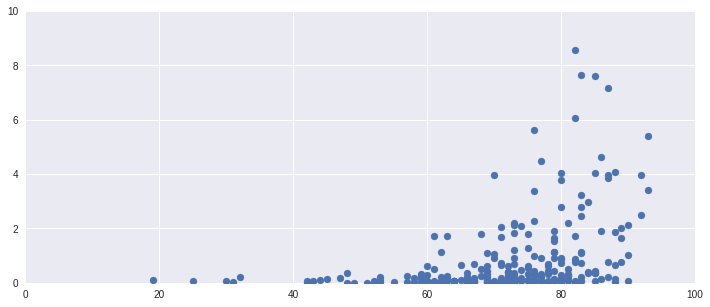

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(
    actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['critic_score'].isna())]['critic_score'],
    actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['critic_score'].isna())]['total_sales']
)
ax.set(
    xlim=(0, 100),
    ylim=(0, 10)
)

plt.show()

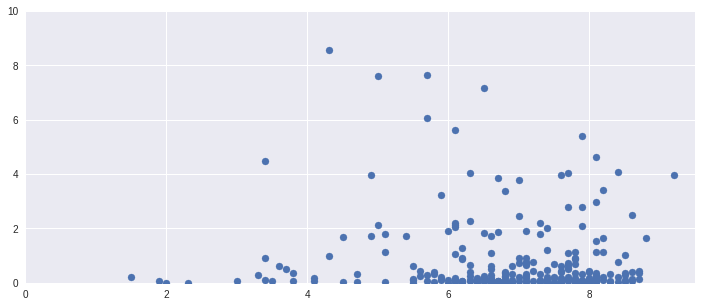

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(
    actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['user_score'].isna())]['user_score'],
    actual_data[(actual_data['platform'] == popular_platform)&(~actual_data['user_score'].isna())]['total_sales']
)
ax.set(
    xlim=(0, 9.5),
    ylim=(0, 10)
)

plt.show()

Не похоже, что есть прямая зависимость между отзывами и продажами на одной из популярных платформ. 

In [52]:
actual_data['total_sales'].dtype

Float64Dtype()

In [53]:
actual_data[actual_data['platform'] == popular_platform]['total_sales'].astype(float).corr(
    actual_data[actual_data['platform'] == popular_platform]['user_score'].astype(float)
)

-0.04029170978314622

Зависимость с оценками пользователей похоже несущественна, либо ее нет.

In [54]:
actual_data[actual_data['platform'] == popular_platform]['total_sales'].astype(float).corr(
    actual_data[actual_data['platform'] == popular_platform]['critic_score'].astype(float)
)

0.3963095483373524

In [55]:
def func(row):
    try:
        return (row['user_score'] * 10 + row['critic_score']) / 2
    except:
        return 0
    
def temp_func(platformi):
    cleared_data['mean_score'] = cleared_data.apply(func,axis=1)
    temp = cleared_data.query('year_of_release == 2016\
                                and platform ==@platformi\
                                and user_score > 0\
                                and critic_score > 0').reset_index(drop=True)
    temp['critic_score'] = temp['critic_score'].astype('float')
    
    fig, axis = plt.subplots(2,2, figsize=(18,10))
    sns.heatmap(temp.loc[:,['total_sales', 'mean_score', 'user_score', 'critic_score']].corr(),annot=True,ax=axis[0,0]);      
    sns.scatterplot(x='mean_score',y='total_sales',hue='mean_score',size='mean_score',sizes=(20,200),data=temp,ax=axis[0,1]);
    sns.scatterplot(x='user_score',y='total_sales',hue='critic_score', size='critic_score',sizes=(20,200), data=temp,ax=axis[1,0]);
    sns.scatterplot(x='critic_score',y='total_sales',hue='user_score', size='user_score',sizes=(20,200), data=temp,ax=axis[1,1]);

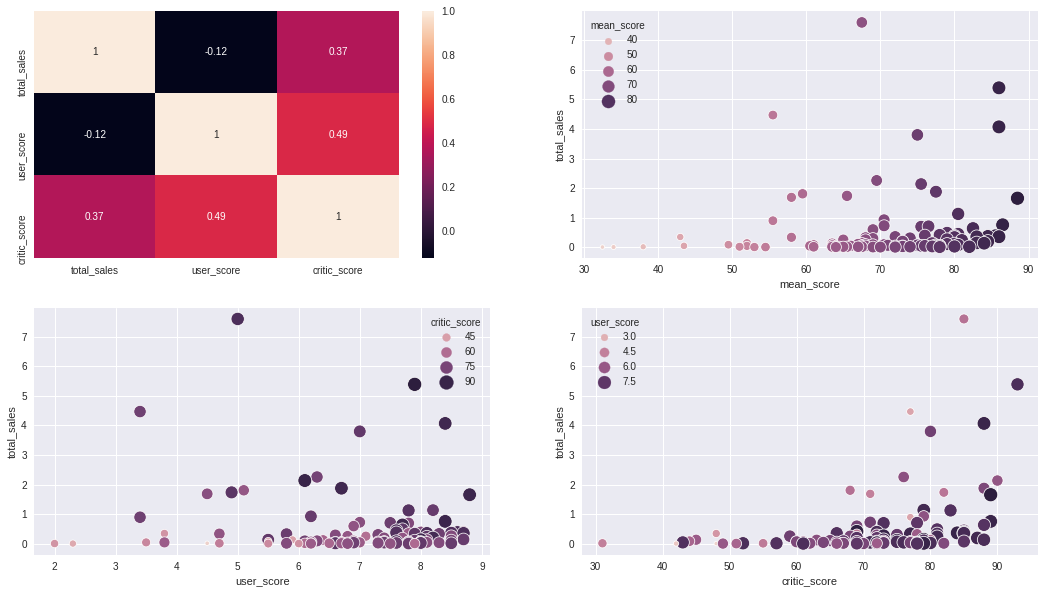

In [56]:
temp_func('PS4')

PS4: Зависимость с пользовательскими отзывами слабая, обратная. Зависимость с отзывами критиков умеренная положительная.

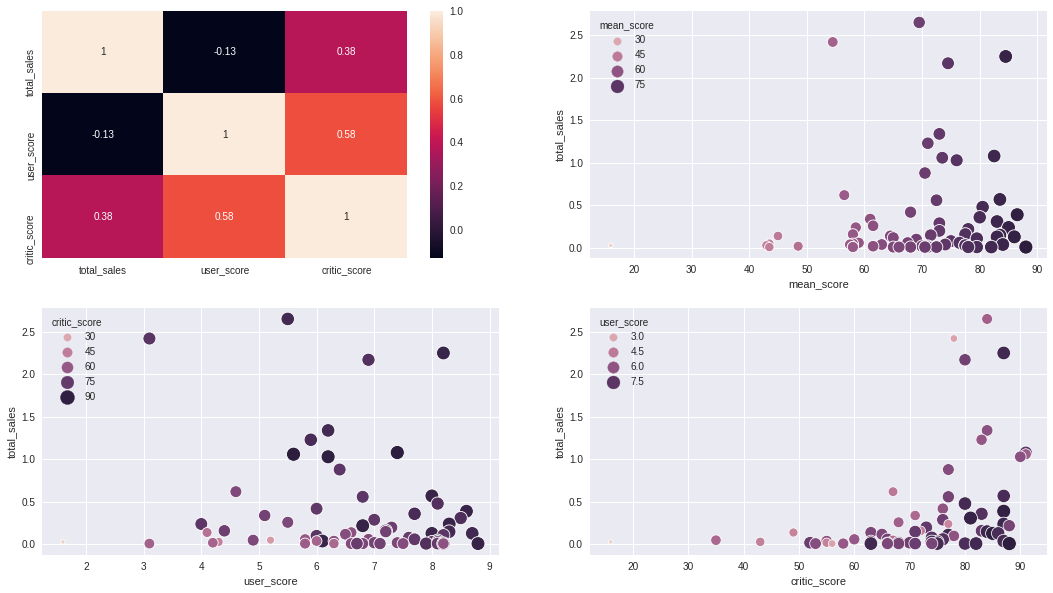

In [57]:
temp_func('XOne')

XOne: Зависимость с пользовательскими отзывами слабая, обратная. Зависимость с отзывами критиков умеренная положительная.

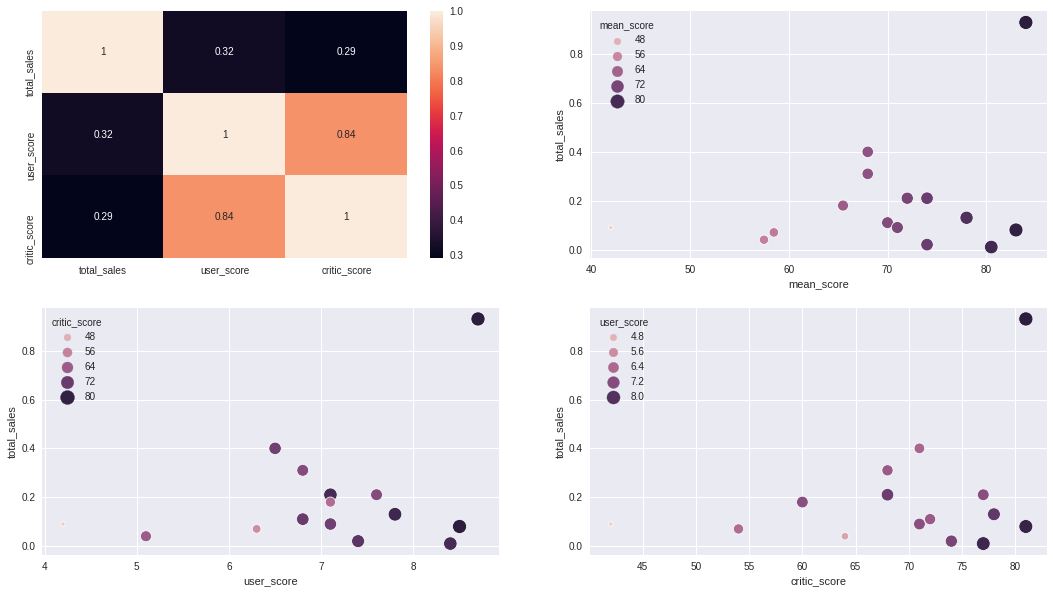

In [58]:
temp_func('3DS')

3DS: Зависимость с пользовательскими отзывами умеренная положительная. Зависимость с отзывами критиков умеренная положительная.

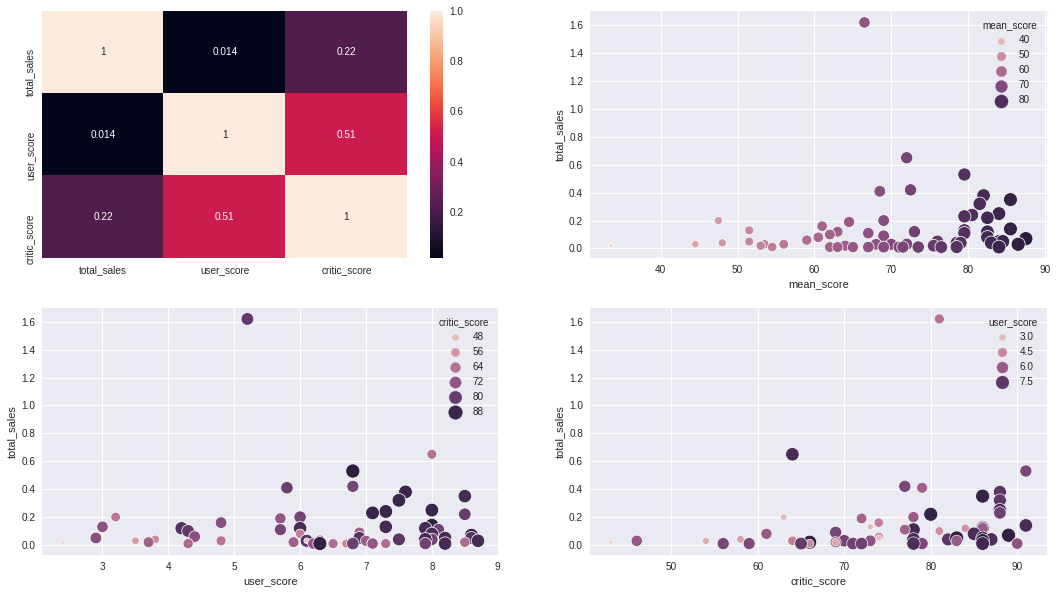

In [59]:
temp_func('PC')

PC: Зависимость с пользовательскими отзывами слабая положительная. Зависимость с отзывами критиков слабая положительная.

Так как PC это исключительная платформа, я не буду ее брать в среднее.

**Промежуточный итог**: 

С 1994-го года популярность игр все растет. За это время было много платформ для них, но в основном они все живут около 10 лет. 


Пользовательские отзывы очень слабо коррелируют с продажами и часто даже отрицательно. Отзывы критиков же средне коррелируют с продажами (0.29 - 0.39). Значит критики лучше прогнозируют успех игры, по сравнению с пользователями.

### Распределение продаж по жанрам

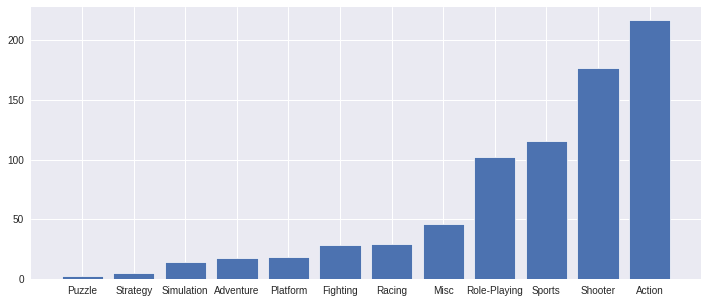

In [60]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(actual_data.groupby('genre')['total_sales'].sum().sort_values().index, 
       actual_data.groupby('genre')['total_sales'].sum().sort_values(),
       edgecolor="white", linewidth=0.7)

ax.plot();

Экшен - самый прибыльный жанр игр. Стратегия - наименее прибыльный из всех жанров.

Три самых прибыльных жанра являются активными. При том экшен довольно сильно опережает спорт.

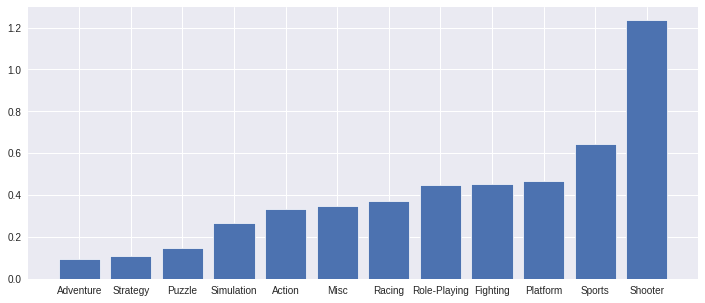

In [61]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(actual_data.groupby('genre')['total_sales'].mean().sort_values().index, 
       actual_data.groupby('genre')['total_sales'].mean().sort_values(),
       edgecolor="white", linewidth=0.7)

ax.plot();

Координальное изменение. Похоже в Action есть несколько очень прибыльных игр, которые и делают суммарную прибыль столь высокой. Однако по медине шутери обгоняют всех, при том в два или более раза. 

Вероятно стоит в смотреть в первую очередь на нишевые шутеры или даже на спортивные игры, нежели на экшен игры, т.к. в последних получают большую прибыль лишь единицы.

## Регионы

### Платформы в регионах

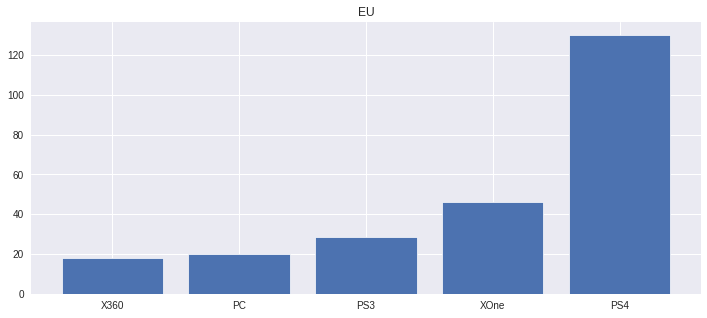

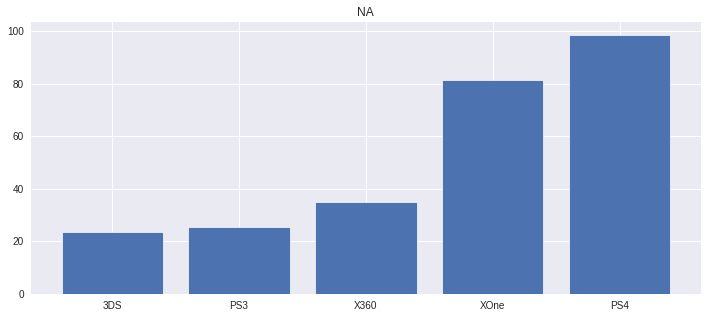

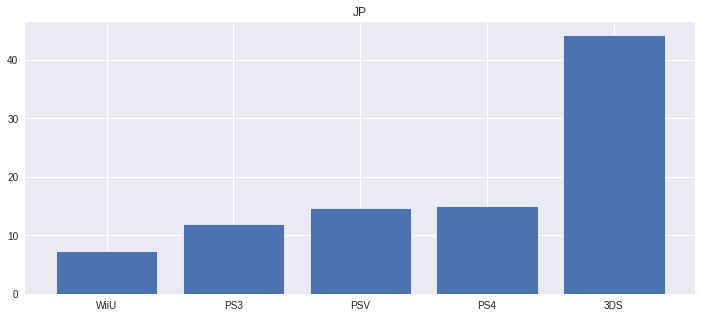

In [62]:
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.bar(actual_data.groupby('platform')[region].sum().sort_values()[-5:].index, 
           actual_data.groupby('platform')[region].sum().sort_values()[-5:],
           edgecolor="white", linewidth=0.7)
    plt.title(region[:2].upper())
    
    ax.plot();

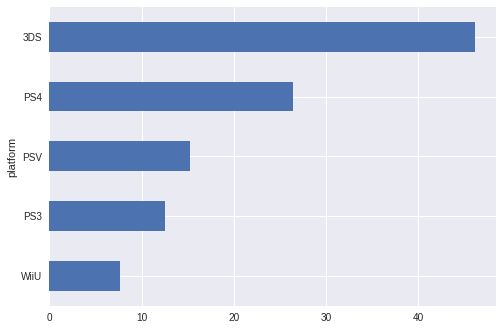

In [63]:

for region in ['eu_sales', 'na_sales', 'jp_sales']:
    (
        actual_data.groupby('platform')[region].sum().sort_values()[-5:] / actual_data[region].sum() * 100
    ).plot.barh()    

В каждом регионе лидирует своя платформа, но если в японии есть однозначный лидер, то в остальных регионах различия не слишком большие.

### Жанры в регионах

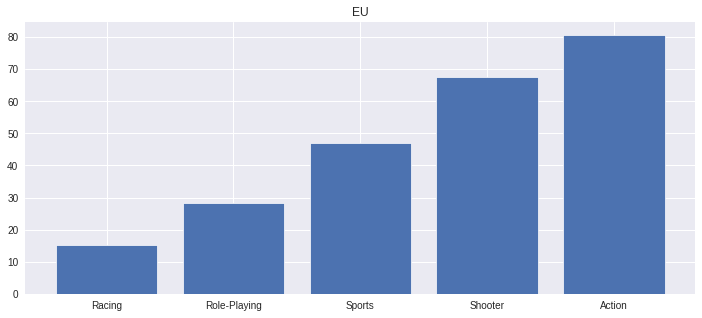

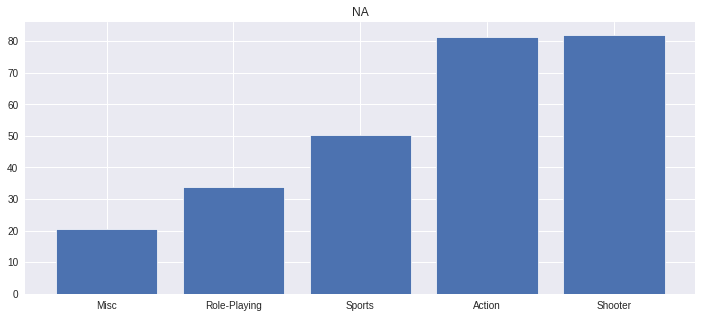

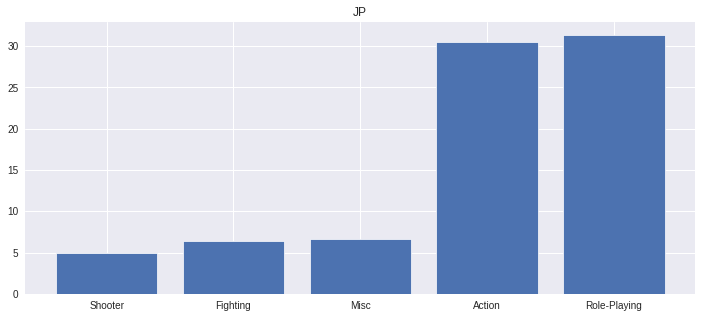

In [64]:
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.bar(actual_data.groupby('genre')[region].sum().sort_values()[-5:].index, 
           actual_data.groupby('genre')[region].sum().sort_values()[-5:],
           edgecolor="white", linewidth=0.7)
    plt.title(region[:2].upper())
    
    ax.plot();

In [65]:
for region in ['eu_sales', 'na_sales', 'jp_sales']:
    print(
        actual_data.groupby('genre')[region].sum().sort_values()[-5:] / actual_data[region].sum()
    )

genre
Racing           0.05369
Role-Playing    0.099972
Sports          0.165338
Shooter         0.238888
Action          0.284641
Name: eu_sales, dtype: Float64
genre
Misc            0.066154
Role-Playing    0.109759
Sports             0.163
Action          0.263805
Shooter         0.265946
Name: na_sales, dtype: Float64
genre
Shooter         0.051525
Fighting        0.066306
Misc            0.069012
Action          0.317165
Role-Playing    0.326429
Name: jp_sales, dtype: Float64


Похоже в Европе и Америке играют примерно в одно и то же, но вот в Японии играют в первую очередь в РПГ.

### Рейтинг ESRB

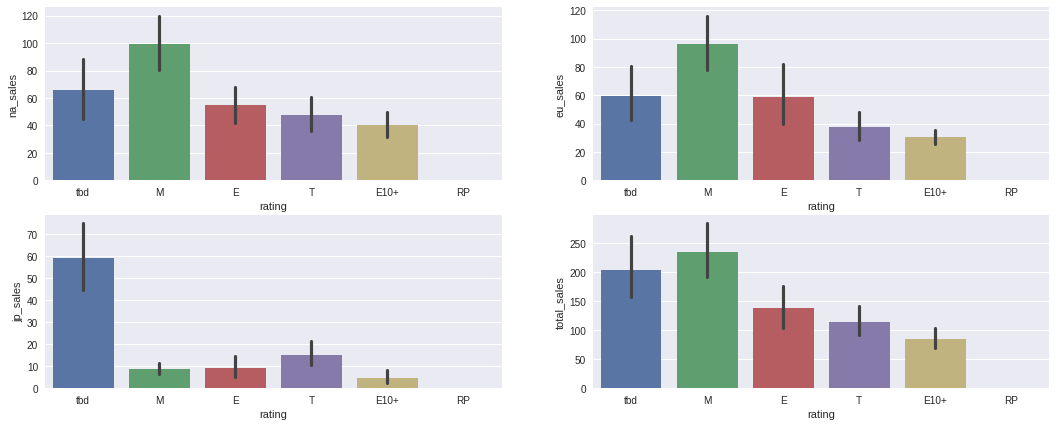

In [66]:
fig, axis = plt.subplots(2,2, figsize=(18,7))
sns.barplot(y='na_sales', x='rating', data = actual_data,estimator=sum, ax=axis[0,0]);
sns.barplot(y='eu_sales', x='rating', data = actual_data,estimator=sum, ax=axis[0,1]);
sns.barplot(y='jp_sales', x='rating', data = actual_data,estimator=sum, ax=axis[1,0]);
sns.barplot(y='total_sales', x='rating', data = actual_data,estimator=sum, ax=axis[1,1]);

Похоже рейтинг рейтинг и правда влияет в зависимости от региона.

В Европе и Америке в первую очередь продаются игры с рейтингом M. В Японии сделать какие-то выводы сложно, потому что очень многие игры не оценены.

## Гипотезы

### Гипотеза №1

*Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые*

Альтернативной гипотезой же будет противоположное условие.

*Н1: Средние пользовательские рейтинги платформ Xbox One и PC различны*

In [67]:
sampl1, sampl2 = (
    actual_data[actual_data['platform'] == 'XOne']['user_score'], 
    actual_data[actual_data['platform'] == 'PC']['user_score']
)

alpha = .05
results = st.ttest_ind(
    sampl1[~sampl1.isna()], sampl2[~sampl2.isna()], equal_var=False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.2206772803661166
Не получилось отвергнуть нулевую гипотезу


### Гипотеза №2

*Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковы*

Альтернативной гипотезой же будет противоположное условие.

*Н1: Средние пользовательские рейтинги жанров Action и Sports разные*

In [68]:
sampl1, sampl2 = (
    actual_data[actual_data['genre'] == 'Action']['user_score'], 
    actual_data[actual_data['genre'] == 'Sports']['user_score']
)

alpha = .05
results = st.ttest_ind(
    sampl1[~sampl1.isna()], sampl2[~sampl2.isna()], equal_var=False
)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  8.360257826703473e-15
Отвергаем нулевую гипотезу


Так как мы взяли за Н0 гипотезу, что рейтинги одинаковы и отверги, значит рейтинги значимо различаются.

## Вывод

Мы исследовали данные по играм до нынешнего года. Мы исследовали зависимость продаж игр от разных факторов.

### Платформы

Выяснилось, что 1994-го года игровая индустрия начала обретать все большую и большую популярность, что привело к ее расрастанию. Но так как платформы в основном живут около 10 лет, то для прогноза решено было использовать данные за последние 12 лет (чуть больше, чем жизнь одной платформы).

Самыми популярными платформами прошлого поколения показались X360, PS3, Wii. Самыми же перспективными оказались PS4, XOne.

### Регионы

Оказывается в Европе и Америке играют в первую очередь в Action, Sports, Action. В Японии же в первую очередь играю в RPG.

В Европе и Америке играют в первую очередь в игры с рейтингом AO, когда в Японии играют E, T и M. Вероятно это значит, что в первых двух регионах играют в основном взрослые, а в последнем играют люди до 18-ти.

### Гипотезы

Было выдвинуто 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action и Sports разные

Первую мы отбросили после T-теста.

Вторая же имеет место быть. Применив доказательство от противного, мы отбросили альтернативную  гипотезу, а потому приняли нулевую.